## Script for Girls' Day 3rd April, 2025

### Data: in folder "output" in cwd (current working directory 

### JGU Jupyter Webserver:

https://cbdm-01.zdv.uni-mainz.de/~muro/teaching/p4b/mod4-2/SoSe23/c0_set_up/c0_jgu_jupyter_notebook_server.html


In [1]:
# imports (pre-installed libraries)
import pandas as pd
import numpy as np
import matplotlib.pyplot as pt
import scipy
import os
import re

In [2]:
#Folder that contains the data we will use
output_folder = './output'

We need a function to load the multi-index data

In [3]:
def load_multi_index_csv_as_df(path, index_cols):
    """
    Loads a CSV and applies transform_df_types, then sets MultiIndex.
    """
    df = pd.read_csv(path)

    # Protect index columns from being cast to int
    preserve_cols = index_cols + ['time_s','batch', 'session', 'rp_rm']
    df = transform_df_types(df, preserve_cols=preserve_cols)

    df.set_index(index_cols, inplace=True)
    return df

def transform_df_types(df, preserve_cols=None):
    """
    Casts numeric columns to int (0,1), casts 'time_s' to float,
    and keeps preserve_cols as strings.
    """
    if preserve_cols is None:
        preserve_cols = ['batch', 'session', 'rp_rm']

    for col in df.columns:
        if col == 'time_s':
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0.0).astype(float)
        elif col in preserve_cols:
            df[col] = df[col].astype(str)
        else:
            df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0).astype(int)

    return df

# 1.) Load the data

In [4]:
data = load_multi_index_csv_as_df('./output/checkpoint_with_index.csv', ['file', 'index'])
print(data.index.names)

['file', 'index']


Take a look on the data:

In [5]:
data

time_s  immobile  csp  csm   id batch session  \
file                index                                                   
990_B_s4_rm_12_4kHz 0         0.00         0    0    0  990     B       4   
                    1         0.04         0    0    0  990     B       4   
                    2         0.08         0    0    0  990     B       4   
                    3         0.12         0    0    0  990     B       4   
                    4         0.16         0    0    0  990     B       4   
...                            ...       ...  ...  ...  ...   ...     ...   
982_A_s5_rm_12_4kHz 40496  1619.84         1    0    0  982     A       5   
                    40497  1619.88         1    0    0  982     A       5   
                    40498  1619.92         1    0    0  982     A       5   
                    40499  1619.96         1    0    0  982     A       5   
                    40500  1620.00         1    0    0  982     A       5   

                          rp_rm  
file                index        
990_B_s4_rm_12_4kHz 0        rm  
                    1        rm  
                    2        rm  
                    3        rm  
                    4        rm  
...                         ...  
982_A_s5_rm_12_4kHz 40496    rm  
                    40497    rm  
                    40498    rm  
                    40499    rm  
                    40500    rm  

[2592064 rows x 8 columns]

In [6]:
data.head() # another function, that only displays the head of the data

time_s  immobile  csp  csm   id batch session rp_rm
file                index                                                     
990_B_s4_rm_12_4kHz 0        0.00         0    0    0  990     B       4    rm
                    1        0.04         0    0    0  990     B       4    rm
                    2        0.08         0    0    0  990     B       4    rm
                    3        0.12         0    0    0  990     B       4    rm
                    4        0.16         0    0    0  990     B       4    rm

## Information about the data 

### The keys

The data contains keys like "990_B_s4_rm_12_4kHz". 

* The first part "990_... is the animal id (number that identifies the animal)
* The second part "_B_" is the batch (we don't need this info today)
* The third part "_s4_" is the session
* The fourth part is the info to which group the animal belongs to: "rm" = R- (suscepptible) and "rp" = R+ (resilient)
* The fifth part is the frequency that has been used for the tone "12_4kHz" or "7_4kHz"

In [7]:
def print_column_dtypes(df):
    print("\n Column Data Types:")
    print("-" * 38)
    for col, dtype in df.dtypes.items():
        print(f"{col:<25} : {dtype}")
        print("-" * 38)
        
        
print_column_dtypes(data)


 Column Data Types:
--------------------------------------
time_s                    : float64
--------------------------------------
immobile                  : int64
--------------------------------------
csp                       : int64
--------------------------------------
csm                       : int64
--------------------------------------
id                        : int64
--------------------------------------
batch                     : object
--------------------------------------
session                   : object
--------------------------------------
rp_rm                     : object
--------------------------------------


## Information about the data: 
### The columns (of each key)

* 	time_s
* immobile

- CS+ (csp = 1/ True) is the "fear tone" - traumatic event is linked to this tone
- CS- (csm = 1/True) is the "safe tone" - nothing bad happened when this tone was on
  
* csp
* csm
* id
* batch
* session
* rp_rm

## For our analysis we want to get the freezing behavior

Freezing refers to the mouse being in enormous fear 

It is defined as "immobile state lasting for at least 2 seconds"

Meaning: we need all freezing events, that last 2 seconds or longer for each key (one animal recorded in one session)

# 2.) Add a new column called "freezing" to our data

We now want to add a column that extracts the "real freezings" for immobile = 1

1 = real freezing event (immobile streak ≥ 25 frames → 1 second)

2 = fake/short freezing event (immobile streak < 25)

0 = not freezing (immobile == 0)

Note: MultiIndex slicing in pandas: you can’t slice unless the index is lexsorted (i.e., sorted properly by all levels)

In [8]:
def add_freezing_column(data, freezing_cuttoff=25):
    """
    Adds a 'freezing' column to the DataFrame:
    - 1: true freezing event (immobile streak >= freezing_cuttoff)
    - 2: short immobile streak (immobile streak < freezing_cuttoff)
    - 0: not immobile
    """
    # Ensure MultiIndex is sorted so slicing works
    data = data.sort_index()  # returns sorted copy, keeps MultiIndex

    data['freezing'] = 0  # initialize

    for file in data.index.levels[0]:
        try:
            df = data.loc[file]
        except KeyError:
            continue

        immobile = df['immobile'].values
        idxs = df.index.values  # these are second-level indices (row indices)

        start = None
        duration = 0

        for i in range(len(immobile)):
            if immobile[i] == 1:
                if start is None:
                    start = idxs[i]
                    duration = 1
                else:
                    duration += 1
            else:
                if start is not None:
                    label = 1 if duration >= freezing_cuttoff else 2 # enter 2 if no "real" freezing
                    data.loc[(file, slice(start, idxs[i - 1])), 'freezing'] = label
                    start = None
                    duration = 0

        # Handle freeze at end of file
        if start is not None:
            label = 1 if duration >= freezing_cuttoff else 2
            data.loc[(file, slice(start, idxs[-1])), 'freezing'] = label

    return data


✅ Sorting the MultiIndex for safe slicing
✅ Looping through each animal (file index)
✅ Tracking immobility streaks
✅ Labeling freezing (as 1), "just" immobile (as 2), and not immobile (as 0)
✅ Handling edge cases at the end of the trace
✅ Modifying the original DataFrame efficiently

In [9]:
data = add_freezing_column(data)

In [10]:
print(data['freezing'].value_counts())

freezing
0    1728710
2     757192
1     106162
Name: count, dtype: int64


In [11]:
# 1.) filter R+ and R- animals

In [13]:
#2.) Filter 

In [14]:
rp_animals = data[data['rp_rm'] == 'rp']
rm_animals = data[data['rp_rm'] == 'rm']


In [15]:
rp_animals


time_s  immobile  csp  csm    id batch session  \
file                 index                                                   
1002_B_s4_rp_12_4kHz 0        0.00         0    0    0  1002     B       4   
                     1        0.04         0    0    0  1002     B       4   
                     10       0.40         0    0    0  1002     B       4   
                     100      4.00         0    0    0  1002     B       4   
                     1000    40.00         1    0    0  1002     B       4   
...                            ...       ...  ...  ...   ...   ...     ...   
988_A_s7_rp_12_4kHz  9995   399.80         0    0    0   988     A       7   
                     9996   399.84         0    0    0   988     A       7   
                     9997   399.88         0    0    0   988     A       7   
                     9998   399.92         0    0    0   988     A       7   
                     9999   399.96         0    0    0   988     A       7   

                           rp_rm  freezing  
file                 index                  
1002_B_s4_rp_12_4kHz 0        rp         0  
                     1        rp         0  
                     10       rp         0  
                     100      rp         0  
                     1000     rp         2  
...                          ...       ...  
988_A_s7_rp_12_4kHz  9995     rp         0  
                     9996     rp         0  
                     9997     rp         0  
                     9998     rp         0  
                     9999     rp         0  

[1134028 rows x 9 columns]

In [16]:
rm_animals

time_s  immobile  csp  csm    id batch session  \
file                index                                                   
1012_B_s4_rm_7_4kHz 0        0.00         0    0    0  1012     B       4   
                    1        0.04         0    0    0  1012     B       4   
                    10       0.40         0    0    0  1012     B       4   
                    100      4.00         0    0    0  1012     B       4   
                    1000    40.00         0    0    0  1012     B       4   
...                           ...       ...  ...  ...   ...   ...     ...   
994_A_s7_rm_12_4kHz 9995   399.80         0    0    0   994     A       7   
                    9996   399.84         0    0    0   994     A       7   
                    9997   399.88         0    0    0   994     A       7   
                    9998   399.92         0    0    0   994     A       7   
                    9999   399.96         1    0    0   994     A       7   

                          rp_rm  freezing  
file                index                  
1012_B_s4_rm_7_4kHz 0        rm         0  
                    1        rm         0  
                    10       rm         0  
                    100      rm         0  
                    1000     rm         0  
...                         ...       ...  
994_A_s7_rm_12_4kHz 9995     rm         0  
                    9996     rm         0  
                    9997     rm         0  
                    9998     rm         0  
                    9999     rm         2  

[1458036 rows x 9 columns]

In [17]:
# we can also use a function to filter rp and the session at the same time

In [18]:
def filter_group_session(df, group='rp', session='4'):
    """
    Filters a MultiIndex dataframe for a given group (rp or rm) and session.
    indef, file as levels
    Parameters:
    - df: MultiIndex DataFrame with 'rp_rm' and 'session' columns
    - group: 'rp' or 'rm'
    - session: e.g., '4', '5', etc. (can also pass as int)

    Returns:
    - Filtered DataFrame
    """
    return df[(df['rp_rm'] == group) & (df['session'] == str(session))].copy()

In [19]:
# filter all sessions in R+

# R+ for all 4 sessions
rp_s4_df = filter_group_session(data, group='rp', session='4')
rp_s5_df = filter_group_session(data, group='rp', session='5')
rp_s6_df = filter_group_session(data, group='rp', session='6')
rp_s7_df = filter_group_session(data, group='rp', session='7')



In [20]:
# TODO: same for R-

# R- for all 4 sessions
rm_s4_df = filter_group_session(data, group='rm', session='4')
rm_s5_df = filter_group_session(data, group='rm', session='5')
rm_s6_df = filter_group_session(data, group='rm', session='6')
rm_s7_df = filter_group_session(data, group='rm', session='7')


In [21]:
rp_s4_df

time_s  immobile  csp  csm    id batch session  \
file                 index                                                   
1002_B_s4_rp_12_4kHz 0        0.00         0    0    0  1002     B       4   
                     1        0.04         0    0    0  1002     B       4   
                     10       0.40         0    0    0  1002     B       4   
                     100      4.00         0    0    0  1002     B       4   
                     1000    40.00         1    0    0  1002     B       4   
...                            ...       ...  ...  ...   ...   ...     ...   
988_A_s4_rp_12_4kHz  9995   399.80         0    0    0   988     A       4   
                     9996   399.84         0    0    0   988     A       4   
                     9997   399.88         0    0    0   988     A       4   
                     9998   399.92         0    0    0   988     A       4   
                     9999   399.96         0    0    0   988     A       4   

                           rp_rm  freezing  
file                 index                  
1002_B_s4_rp_12_4kHz 0        rp         0  
                     1        rp         0  
                     10       rp         0  
                     100      rp         0  
                     1000     rp         2  
...                          ...       ...  
988_A_s4_rp_12_4kHz  9995     rp         0  
                     9996     rp         0  
                     9997     rp         0  
                     9998     rp         0  
                     9999     rp         0  

[283507 rows x 9 columns]

In [22]:
def compute_freezing_by_tone(df, n_csp=12, n_csm=4):
    """
    Computes total and normalized freezing counts during CS+ and CS− tones only.

    Parameters:
    - df: filtered MultiIndex dataframe (e.g., rp_s4_df)
    - n_csp: number of CS+ tones in session
    - n_csm: number of CS− tones in session

    Returns:
    - Dictionary with total freezing counts & average freezing per tone
    """
    # Ensure correct types (esp. if loaded from CSV)
    df['freezing'] = df['freezing'].astype(int)
    df['csp'] = df['csp'].astype(int)
    df['csm'] = df['csm'].astype(int)

    # ❗ Only count freezing frames DURING tones
    csp_freeze_count = df[(df['freezing'] == 1) & (df['csp'] == 1)].shape[0]
    csm_freeze_count = df[(df['freezing'] == 1) & (df['csm'] == 1)].shape[0]

    csp_per_tone = csp_freeze_count / n_csp if n_csp else 0
    csm_per_tone = csm_freeze_count / n_csm if n_csm else 0

    return {
        'csp_freeze_total': csp_freeze_count,
        'csm_freeze_total': csm_freeze_count,
        'csp_per_tone': csp_per_tone,
        'csm_per_tone': csm_per_tone
    }


In [23]:
# example

result_rp_s4 = compute_freezing_by_tone(rp_s4_df)
result_rm_s4 = compute_freezing_by_tone(rm_s4_df)

print("R+ Session 4:", result_rp_s4)
print("R− Session 4:", result_rm_s4)


R+ Session 4: {'csp_freeze_total': 4579, 'csm_freeze_total': 1224, 'csp_per_tone': 381.5833333333333, 'csm_per_tone': 306.0}
R− Session 4: {'csp_freeze_total': 6889, 'csm_freeze_total': 1508, 'csp_per_tone': 574.0833333333334, 'csm_per_tone': 377.0}


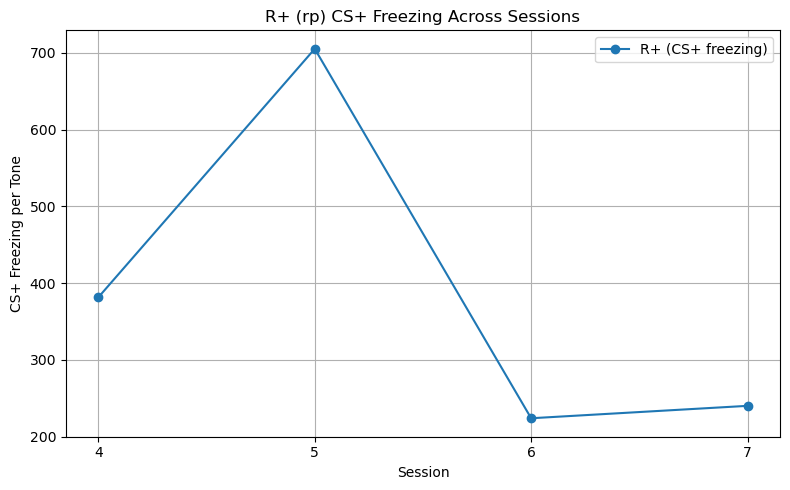

In [24]:
import matplotlib.pyplot as plt

# Sessions to plot
sessions = ['4', '5', '6', '7']
rp_csp_per_tone = []

# Compute per session
for session in sessions:
    rp_df = filter_group_session(data, group='rp', session=session)
    stats = compute_freezing_by_tone(rp_df)
    rp_csp_per_tone.append(stats['csp_per_tone'])

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(sessions, rp_csp_per_tone, marker='o', label='R+ (CS+ freezing)')
plt.xlabel('Session')
plt.ylabel('CS+ Freezing per Tone')
plt.title('R+ (rp) CS+ Freezing Across Sessions')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


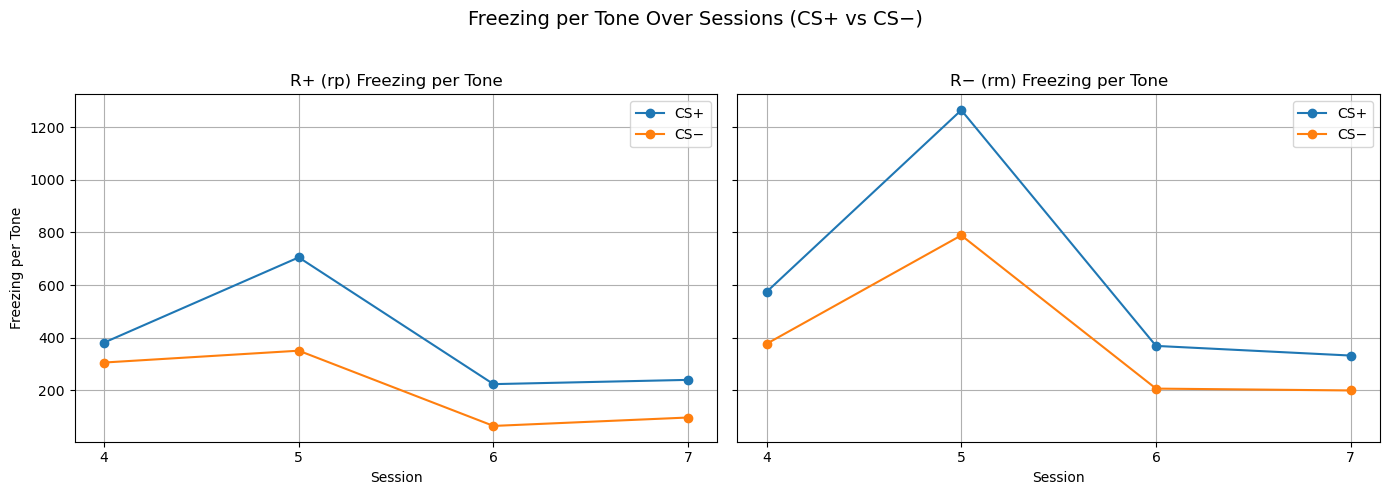

In [26]:
import matplotlib.pyplot as plt

# Sessions to plot
sessions = ['4', '5', '6', '7']
rp_csp, rp_csm = [], []
rm_csp, rm_csm = [], []

# Compute stats for each group/session
for session in sessions:
    rp_df = filter_group_session(data, group='rp', session=session)
    rm_df = filter_group_session(data, group='rm', session=session)

    rp_stats = compute_freezing_by_tone(rp_df)
    rm_stats = compute_freezing_by_tone(rm_df)

    rp_csp.append(rp_stats['csp_per_tone'])
    rp_csm.append(rp_stats['csm_per_tone'])
    rm_csp.append(rm_stats['csp_per_tone'])
    rm_csm.append(rm_stats['csm_per_tone'])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# R+ subplot
axes[0].plot(sessions, rp_csp, marker='o', label='CS+')
axes[0].plot(sessions, rp_csm, marker='o', label='CS−')
axes[0].set_title('R+ (rp) Freezing per Tone')
axes[0].set_xlabel('Session')
axes[0].set_ylabel('Freezing per Tone')
axes[0].legend()
axes[0].grid(True)

# R− subplot
axes[1].plot(sessions, rm_csp, marker='o', label='CS+')
axes[1].plot(sessions, rm_csm, marker='o', label='CS−')
axes[1].set_title('R− (rm) Freezing per Tone')
axes[1].set_xlabel('Session')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Freezing per Tone Over Sessions (CS+ vs CS−)', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [30]:
""" need to replace the tone dict!!!! """

fps = 25  # Frames per second

# Tone 1 (CS−, habituation?)
tone1_start = 180 * fps
tone1_duration = 30 * fps
tone1_break = 60 * fps
tone1_reps = 4

# Tone 2 (CS+, main tones)
tone2_start = tone1_start + tone1_reps * (tone1_duration + tone1_break)
tone2_duration = 30 * fps
tone2_break = 60 * fps
tone2_reps = 12

# Calculate CS− epochs
csm_epochs = []
for i in range(tone1_reps):
    start = tone1_start + i * (tone1_duration + tone1_break)
    end = start + tone1_duration
    csm_epochs.append((int(start), int(end)))

# Calculate CS+ epochs
csp_epochs = []
for i in range(tone2_reps):
    start = tone2_start + i * (tone2_duration + tone2_break)
    end = start + tone2_duration
    csp_epochs.append((int(start), int(end)))

# Combine into shared dictionary
shared_tone_epochs = {
    'csp': csp_epochs,
    'csm': csm_epochs
}

# Optional: check them
print("CS− epochs:", csm_epochs)
print("CS+ epochs:", csp_epochs)
print("Master file epochs:", shared_tone_epochs)

CS− epochs: [(4500, 5250), (6750, 7500), (9000, 9750), (11250, 12000)]
CS+ epochs: [(13500, 14250), (15750, 16500), (18000, 18750), (20250, 21000), (22500, 23250), (24750, 25500), (27000, 27750), (29250, 30000), (31500, 32250), (33750, 34500), (36000, 36750), (38250, 39000)]
Master file epochs: {'csp': [(13500, 14250), (15750, 16500), (18000, 18750), (20250, 21000), (22500, 23250), (24750, 25500), (27000, 27750), (29250, 30000), (31500, 32250), (33750, 34500), (36000, 36750), (38250, 39000)], 'csm': [(4500, 5250), (6750, 7500), (9000, 9750), (11250, 12000)]}


In [31]:
# heatmap

import matplotlib.pyplot as plt
import numpy as np

def plot_csm_aligned_freezing_heatmap(data, shared_tone_epochs, session='4', fps=25,
                                       pre_tone=30, post_tone=30, bin_size=1):
    frame_duration = 1 / fps
    tone_epochs = shared_tone_epochs['csm']
    tone_starts = [start * frame_duration for start, _ in tone_epochs]
    tone_durations = [end - start for start, end in tone_epochs]
    mean_duration = np.mean([dur * frame_duration for dur in tone_durations])

    bins = np.arange(-pre_tone, mean_duration + post_tone + bin_size, bin_size)

    heatmaps = {'rp': [], 'rm': []}
    labels = {'rp': [], 'rm': []}

    df = data[(data['session'] == str(session)) & (data['freezing'] == 1)]

    for file in df.index.levels[0]:
        try:
            file_df = df.loc[file]
        except KeyError:
            continue

        group = file_df['rp_rm'].iloc[0]
        times = file_df['time_s'].values
        animal_id = str(file).split('_')[0]

        aligned_epochs = []
        for tone_start, tone_dur_frames in tone_epochs:
            tone_start_s = tone_start * frame_duration
            tone_dur_s = tone_dur_frames * frame_duration

            start = tone_start_s - pre_tone
            end = tone_start_s + tone_dur_s + post_tone

            epoch_times = times[(times >= start) & (times < end)] - tone_start_s
            bin_counts, _ = np.histogram(epoch_times, bins=bins)
            aligned_epochs.append(bin_counts)

        if aligned_epochs:
            matrix = np.vstack(aligned_epochs)
            heatmaps[group].append(matrix)
            labels[group].extend([f"{animal_id}_tone{i+1}" for i in range(len(aligned_epochs))])

    fig, axes = plt.subplots(1, 2, figsize=(16, 10), constrained_layout=True, sharey=True)
    vmin, vmax = 0, 10
    xticks = bins[::5]
    xticklabels = [f"{x:.0f}" for x in xticks]

    def plot_group(ax, matrices, group_labels, title):
        if not matrices:
            ax.set_title(f"{title}\n(No Data)")
            return
        data_matrix = np.vstack(matrices)
        im = ax.imshow(data_matrix, aspect='auto', cmap='Blues', vmin=vmin, vmax=vmax,
                       interpolation='none', extent=[bins[0], bins[-1], 0, data_matrix.shape[0]])
        ax.set_yticks(np.arange(len(group_labels)) + 0.5)
        ax.set_yticklabels(group_labels)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.axvline(0, color='green', linestyle='--', label='CS− Start')
        ax.axvline(mean_duration, color='green', linestyle='-', label='CS− End')
        ax.set_title(title)
        ax.set_xlabel('Time (s)')
        return im

    im_rp = plot_group(axes[0], heatmaps['rp'], labels['rp'], 'R+ (rp) CS−-Aligned Freezing')
    im_rm = plot_group(axes[1], heatmaps['rm'], labels['rm'], 'R− (rm) CS−-Aligned Freezing')

    axes[0].set_ylabel('Animal / Tone Epoch')

    cbar = fig.colorbar(im_rp if im_rp else im_rm, ax=axes, location='right', shrink=0.8, pad=0.05)
    cbar.set_label(f'Freezing count per {bin_size}s bin')

    handles = [
        plt.Line2D([0], [0], color='green', linestyle='--', label='CS− start'),
        plt.Line2D([0], [0], color='green', linestyle='-', label='CS− end')
    ]
    axes[1].legend(handles=handles, loc='upper right')
    plt.suptitle(f"Freezing Aligned to CS− (Session {session})", fontsize=14)
    plt.show()


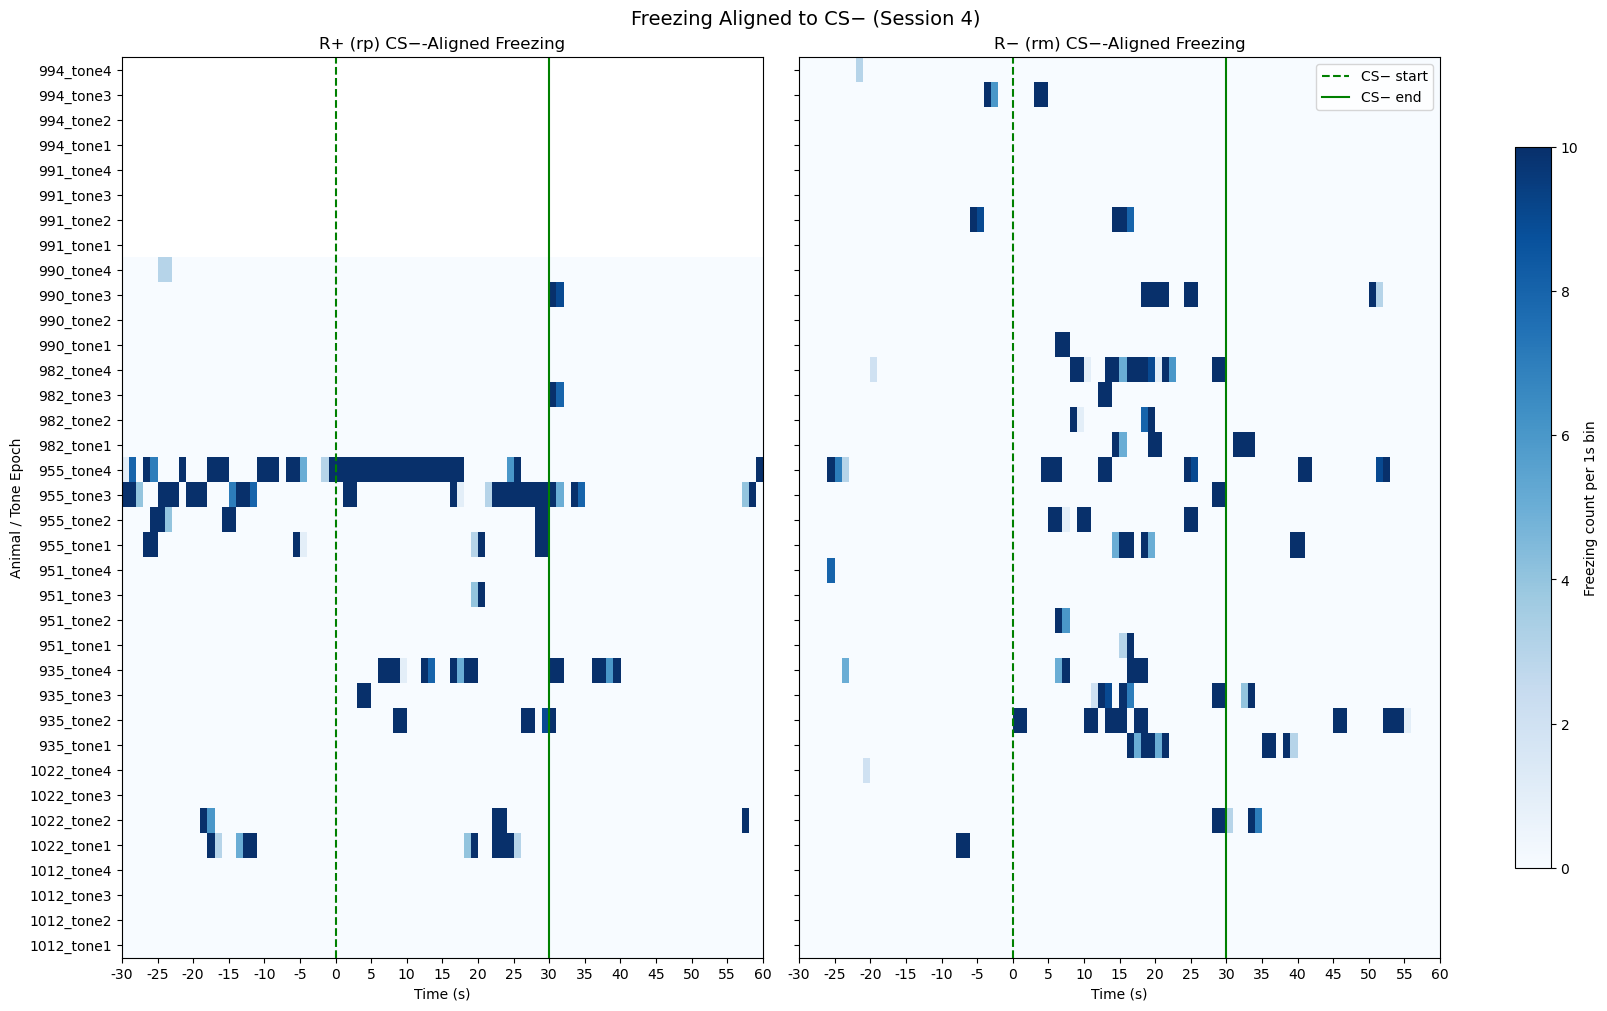

In [32]:
plot_csm_aligned_freezing_heatmap(data, shared_tone_epochs, session='4', fps=25,
                                       pre_tone=30, post_tone=30, bin_size=1)

In [33]:
# Using log scale

#using a logarithmic color scale can help reveal subtle freezing patterns, 
# especially when most bins are near zero but a few have high counts

In [34]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_csm_aligned_freezing_heatmap(data, shared_tone_epochs, session='4', fps=25,
                                       pre_tone=30, post_tone=30, bin_size=1):
    """
    Heatmap of freezing (freezing == 1) aligned to CS− (csm) tones,
    showing 30s before and after tone onset, for R+ and R− animals.
    Log-scaled color map to reveal sparse freezing patterns.
    """
    frame_duration = 1 / fps
    tone_epochs = shared_tone_epochs['csm']
    tone_starts = [start * frame_duration for start, _ in tone_epochs]
    tone_durations = [end - start for start, end in tone_epochs]
    tone_durations_sec = [dur * frame_duration for dur in tone_durations]
    mean_duration = np.mean(tone_durations_sec)

    # Bin edges from -30 to +tone duration + 30
    bins = np.arange(-pre_tone, mean_duration + post_tone + bin_size, bin_size)

    heatmaps = {'rp': [], 'rm': []}
    labels = {'rp': [], 'rm': []}

    # Filter data to current session and freezing only
    df = data[(data['session'] == str(session)) & (data['freezing'] == 1)]

    for file in df.index.levels[0]:
        try:
            file_df = df.loc[file]
        except KeyError:
            continue

        group = file_df['rp_rm'].iloc[0]
        times = file_df['time_s'].values
        animal_id = str(file).split('_')[0]

        aligned_epochs = []
        for i, (tone_start_f, tone_end_f) in enumerate(tone_epochs):
            tone_start_s = tone_start_f * frame_duration
            tone_dur_s = (tone_end_f - tone_start_f) * frame_duration

            start = tone_start_s - pre_tone
            end = tone_start_s + tone_dur_s + post_tone

            # Shift to align time to tone_start_s (0)
            epoch_times = times[(times >= start) & (times < end)] - tone_start_s
            bin_counts, _ = np.histogram(epoch_times, bins=bins)
            aligned_epochs.append(bin_counts)

        if aligned_epochs:
            matrix = np.vstack(aligned_epochs)
            heatmaps[group].append(matrix)
            labels[group].extend([f"{animal_id}_tone{i+1}" for i in range(len(aligned_epochs))])

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 10), constrained_layout=True, sharey=True)
    xticks = bins[::5]
    xticklabels = [f"{x:.0f}" for x in xticks]

    def plot_group(ax, matrices, group_labels, title):
        if not matrices:
            ax.set_title(f"{title}\n(No Data)")
            return None
        data_matrix = np.vstack(matrices)

        # Use log scale if non-zero data exists
        if np.count_nonzero(data_matrix) > 0:
            norm = mcolors.LogNorm(vmin=1, vmax=max(2, data_matrix.max()))
        else:
            norm = None

        im = ax.imshow(
            data_matrix,
            aspect='auto',
            cmap='Blues',
            interpolation='none',
            extent=[bins[0], bins[-1], 0, data_matrix.shape[0]],
            norm=norm
        )
        ax.set_yticks(np.arange(len(group_labels)) + 0.5)
        ax.set_yticklabels(group_labels)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.axvline(0, color='green', linestyle='--', label='CS− Start')
        ax.axvline(mean_duration, color='green', linestyle='-', label='CS− End')
        ax.set_title(title)
        ax.set_xlabel('Time (s)')
        return im

    # R+ (rp)
    im_rp = plot_group(axes[0], heatmaps['rp'], labels['rp'], 'R+ (rp) CS−-Aligned Freezing')

    # R− (rm)
    im_rm = plot_group(axes[1], heatmaps['rm'], labels['rm'], 'R− (rm) CS−-Aligned Freezing')

    axes[0].set_ylabel('Animal / Tone Epoch')

    # Colorbar
    cbar = fig.colorbar(im_rp if im_rp else im_rm, ax=axes, location='right', shrink=0.8, pad=0.05)
    cbar.set_label('Freezing count (log-scaled)')

    # Legend
    handles = [
        plt.Line2D([0], [0], color='green', linestyle='--', label='CS− start'),
        plt.Line2D([0], [0], color='green', linestyle='-', label='CS− end')
    ]
    axes[1].legend(handles=handles, loc='upper right')

    plt.suptitle(f'Freezing Aligned to CS− Tone (Session {session})', fontsize=14)
    plt.show()


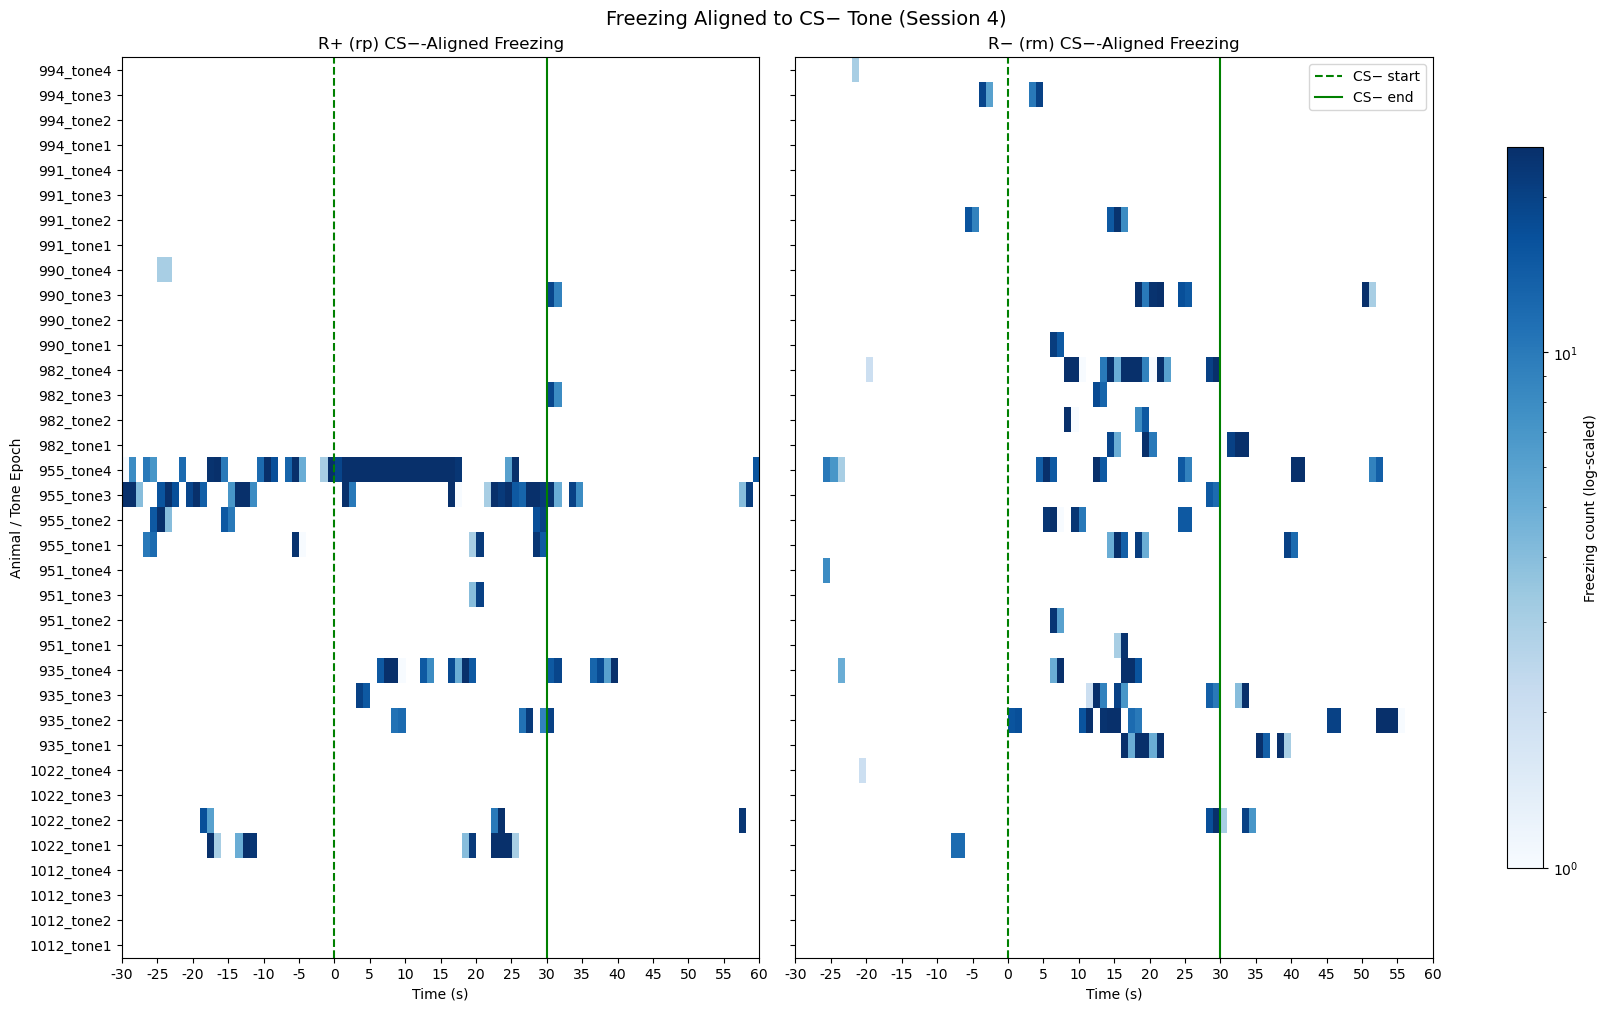

In [35]:
plot_csm_aligned_freezing_heatmap(data, shared_tone_epochs, session='4', fps=25,
                                       pre_tone=30, post_tone=30, bin_size=1)

In [36]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_csp_aligned_freezing_heatmap(data, shared_tone_epochs, session='4', fps=25,
                                       pre_tone=30, post_tone=30, bin_size=1):
    """
    Heatmap of freezing (freezing == 1) aligned to CS+ (csp) tones,
    showing 30s before and after tone onset, for R+ and R− animals.
    Log-scaled color map for stronger visual contrast.
    """
    frame_duration = 1 / fps
    tone_epochs = shared_tone_epochs['csp']
    tone_starts = [start * frame_duration for start, _ in tone_epochs]
    tone_durations = [end - start for start, end in tone_epochs]
    tone_durations_sec = [dur * frame_duration for dur in tone_durations]
    mean_duration = np.mean(tone_durations_sec)

    bins = np.arange(-pre_tone, mean_duration + post_tone + bin_size, bin_size)

    heatmaps = {'rp': [], 'rm': []}
    labels = {'rp': [], 'rm': []}

    # Filter data for current session & freezing only
    df = data[(data['session'] == str(session)) & (data['freezing'] == 1)]

    for file in df.index.levels[0]:
        try:
            file_df = df.loc[file]
        except KeyError:
            continue

        group = file_df['rp_rm'].iloc[0]
        times = file_df['time_s'].values
        animal_id = str(file).split('_')[0]

        aligned_epochs = []
        for i, (tone_start_f, tone_end_f) in enumerate(tone_epochs):
            tone_start_s = tone_start_f * frame_duration
            tone_dur_s = (tone_end_f - tone_start_f) * frame_duration

            start = tone_start_s - pre_tone
            end = tone_start_s + tone_dur_s + post_tone

            epoch_times = times[(times >= start) & (times < end)] - tone_start_s
            bin_counts, _ = np.histogram(epoch_times, bins=bins)
            aligned_epochs.append(bin_counts)

        if aligned_epochs:
            matrix = np.vstack(aligned_epochs)
            heatmaps[group].append(matrix)
            labels[group].extend([f"{animal_id}_tone{i+1}" for i in range(len(aligned_epochs))])
            

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 10), constrained_layout=True, sharey=True)
    xticks = bins[::5]
    xticklabels = [f"{x:.0f}" for x in xticks]

    def plot_group(ax, matrices, group_labels, title):
        if not matrices:
            ax.set_title(f"{title}\n(No Data)")
            return None
        data_matrix = np.vstack(matrices)

        if np.count_nonzero(data_matrix) > 0:
            norm = mcolors.LogNorm(vmin=1, vmax=data_matrix.max())
        else:
            norm = None

        im = ax.imshow(
            data_matrix,
            aspect='auto',
            cmap='magma',
            interpolation='none',
            extent=[bins[0], bins[-1], 0, data_matrix.shape[0]],
            norm=norm
        )
        ax.set_yticks(np.arange(len(group_labels)) + 0.5)
        ax.set_yticklabels(group_labels)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.axvline(0, color='red', linestyle='--', linewidth=2, label='CS+ Start')
        ax.axvline(mean_duration, color='red', linestyle='-', linewidth=2, label='CS+ End')
        ax.set_title(title)
        ax.set_xlabel('Time (s)')
        return im

    im_rp = plot_group(axes[0], heatmaps['rp'], labels['rp'], 'R+ (rp) CS+-Aligned Freezing')
    im_rm = plot_group(axes[1], heatmaps['rm'], labels['rm'], 'R− (rm) CS+-Aligned Freezing')

    axes[0].set_ylabel('Animal / Tone Epoch')

    cbar = fig.colorbar(im_rp if im_rp else im_rm, ax=axes, location='right', shrink=0.8, pad=0.05)
    cbar.set_label('Freezing count (log-scaled)')

    handles = [
        plt.Line2D([0], [0], color='red', linestyle='--', linewidth=2, label='CS+ start'),
        plt.Line2D([0], [0], color='red', linestyle='-', linewidth=2, label='CS+ end')
    ]
    axes[1].legend(handles=handles, loc='upper right')

    plt.suptitle(f'Freezing Aligned to CS+ Tone (Session {session})', fontsize=14)
    plt.show()


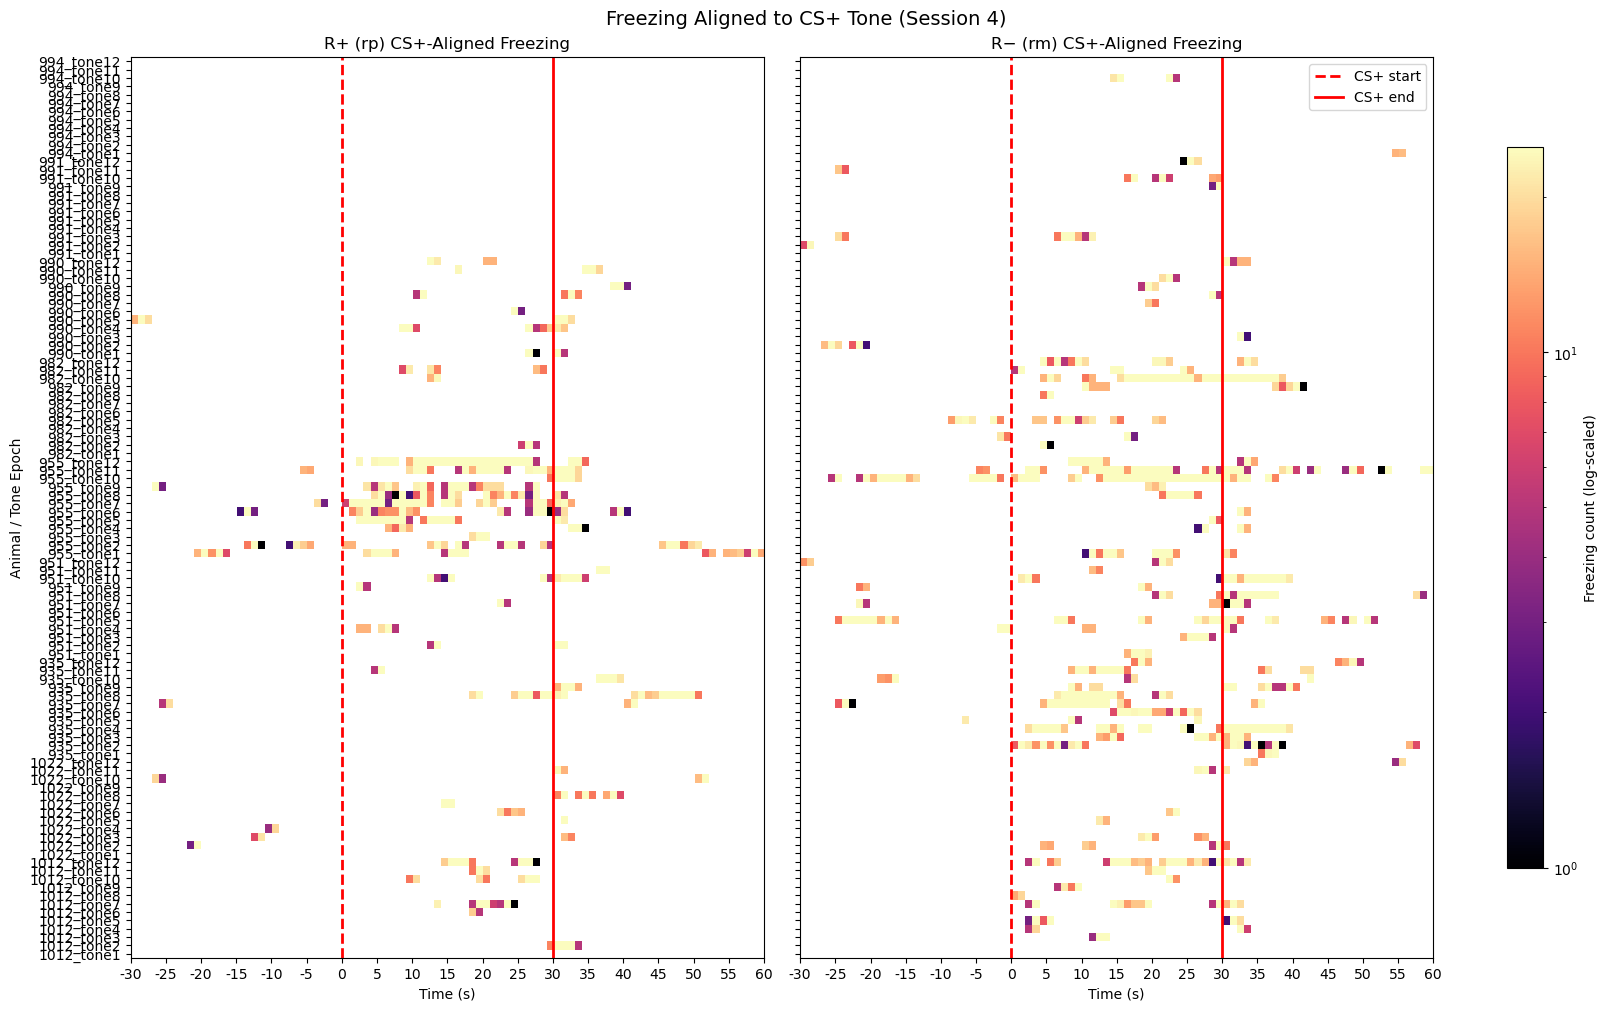

In [37]:
plot_csp_aligned_freezing_heatmap(data, shared_tone_epochs, session='4', fps=25,
                                       pre_tone=30, post_tone=30, bin_size=1)

In [38]:
""" add blank space for new animal"""

' add blank space for new animal'

In [39]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np

def plot_tone_aligned_freezing_heatmap(
    data, shared_tone_epochs, session='4', tone_type='csp',
    fps=25, pre_tone=30, post_tone=30, bin_size=1
):
    """
    Plot R+ and R− heatmaps of freezing aligned to CS+ or CS− tones.
    
    Parameters:
    - data: full dataframe with MultiIndex and 'freezing', 'rp_rm', 'time_s'
    - shared_tone_epochs: dict with 'csp' and 'csm' tone (start, end) tuples
    - session: session ID (str or int)
    - tone_type: 'csp' (CS+) or 'csm' (CS−)
    - fps: frames per second (default: 25)
    - pre_tone / post_tone: time before and after tone onset (seconds)
    - bin_size: size of time bins (seconds)
    """
    assert tone_type in ['csp', 'csm'], "tone_type must be 'csp' or 'csm'"

    frame_duration = 1 / fps
    tone_epochs = shared_tone_epochs[tone_type]
    tone_durations = [(end - start) * frame_duration for start, end in tone_epochs]
    mean_duration = np.mean(tone_durations)

    bins = np.arange(-pre_tone, mean_duration + post_tone + bin_size, bin_size)

    heatmaps = {'rp': [], 'rm': []}
    labels = {'rp': [], 'rm': []}

    df = data[(data['session'] == str(session)) & (data['freezing'] == 1)]

    for file in df.index.levels[0]:
        try:
            file_df = df.loc[file]
        except KeyError:
            continue

        group = file_df['rp_rm'].iloc[0]
        times = file_df['time_s'].values
        animal_id = str(file).split('_')[0]

        aligned_epochs = []
        for i, (tone_start_f, tone_end_f) in enumerate(tone_epochs):
            tone_start_s = tone_start_f * frame_duration
            tone_dur_s = (tone_end_f - tone_start_f) * frame_duration

            start = tone_start_s - pre_tone
            end = tone_start_s + tone_dur_s + post_tone

            epoch_times = times[(times >= start) & (times < end)] - tone_start_s
            bin_counts, _ = np.histogram(epoch_times, bins=bins)
            aligned_epochs.append(bin_counts)

        if aligned_epochs:
            matrix = np.vstack(aligned_epochs)

            # Add blank row between animals
            spacer = np.zeros((1, matrix.shape[1]), dtype=int)
            matrix_with_space = np.vstack([matrix, spacer])

            heatmaps[group].append(matrix_with_space)
            labels[group].extend([f"{animal_id}_tone{i+1}" for i in range(len(aligned_epochs))] + [''])

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(16, 10), constrained_layout=True, sharey=True)
    xticks = bins[::5]
    xticklabels = [f"{x:.0f}" for x in xticks]

    def plot_group(ax, matrices, group_labels, title, color):
        if not matrices:
            ax.set_title(f"{title}\n(No Data)")
            return None
        data_matrix = np.vstack(matrices)

        if np.count_nonzero(data_matrix) > 0:
            norm = mcolors.LogNorm(vmin=1, vmax=data_matrix.max())
        else:
            norm = None

        im = ax.imshow(
            data_matrix,
            aspect='auto',
            cmap='magma',
            interpolation='none',
            extent=[bins[0], bins[-1], 0, data_matrix.shape[0]],
            norm=norm
        )
        ax.set_yticks(np.arange(len(group_labels)) + 0.5)
        ax.set_yticklabels(group_labels)
        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)
        ax.axvline(0, color=color, linestyle='--', linewidth=2, label=f'{tone_type.upper()} Start')
        ax.axvline(mean_duration, color=color, linestyle='-', linewidth=2, label=f'{tone_type.upper()} End')
        ax.set_title(title)
        ax.set_xlabel('Time (s)')
        return im

    color = 'red' if tone_type == 'csp' else 'green'

    im_rp = plot_group(axes[0], heatmaps['rp'], labels['rp'], f'R+ (rp) {tone_type.upper()}-Aligned Freezing', color)
    im_rm = plot_group(axes[1], heatmaps['rm'], labels['rm'], f'R− (rm) {tone_type.upper()}-Aligned Freezing', color)

    axes[0].set_ylabel('Animal / Tone Epoch')

    cbar = fig.colorbar(im_rp if im_rp else im_rm, ax=axes, location='right', shrink=0.8, pad=0.05)
    cbar.set_label('Freezing count (log-scaled)')

    handles = [
        plt.Line2D([0], [0], color=color, linestyle='--', linewidth=2, label=f'{tone_type.upper()} start'),
        plt.Line2D([0], [0], color=color, linestyle='-', linewidth=2, label=f'{tone_type.upper()} end')
    ]
    axes[1].legend(handles=handles, loc='upper right')

    plt.suptitle(f'Freezing Aligned to {tone_type.upper()} Tone (Session {session})', fontsize=14)
    plt.show()


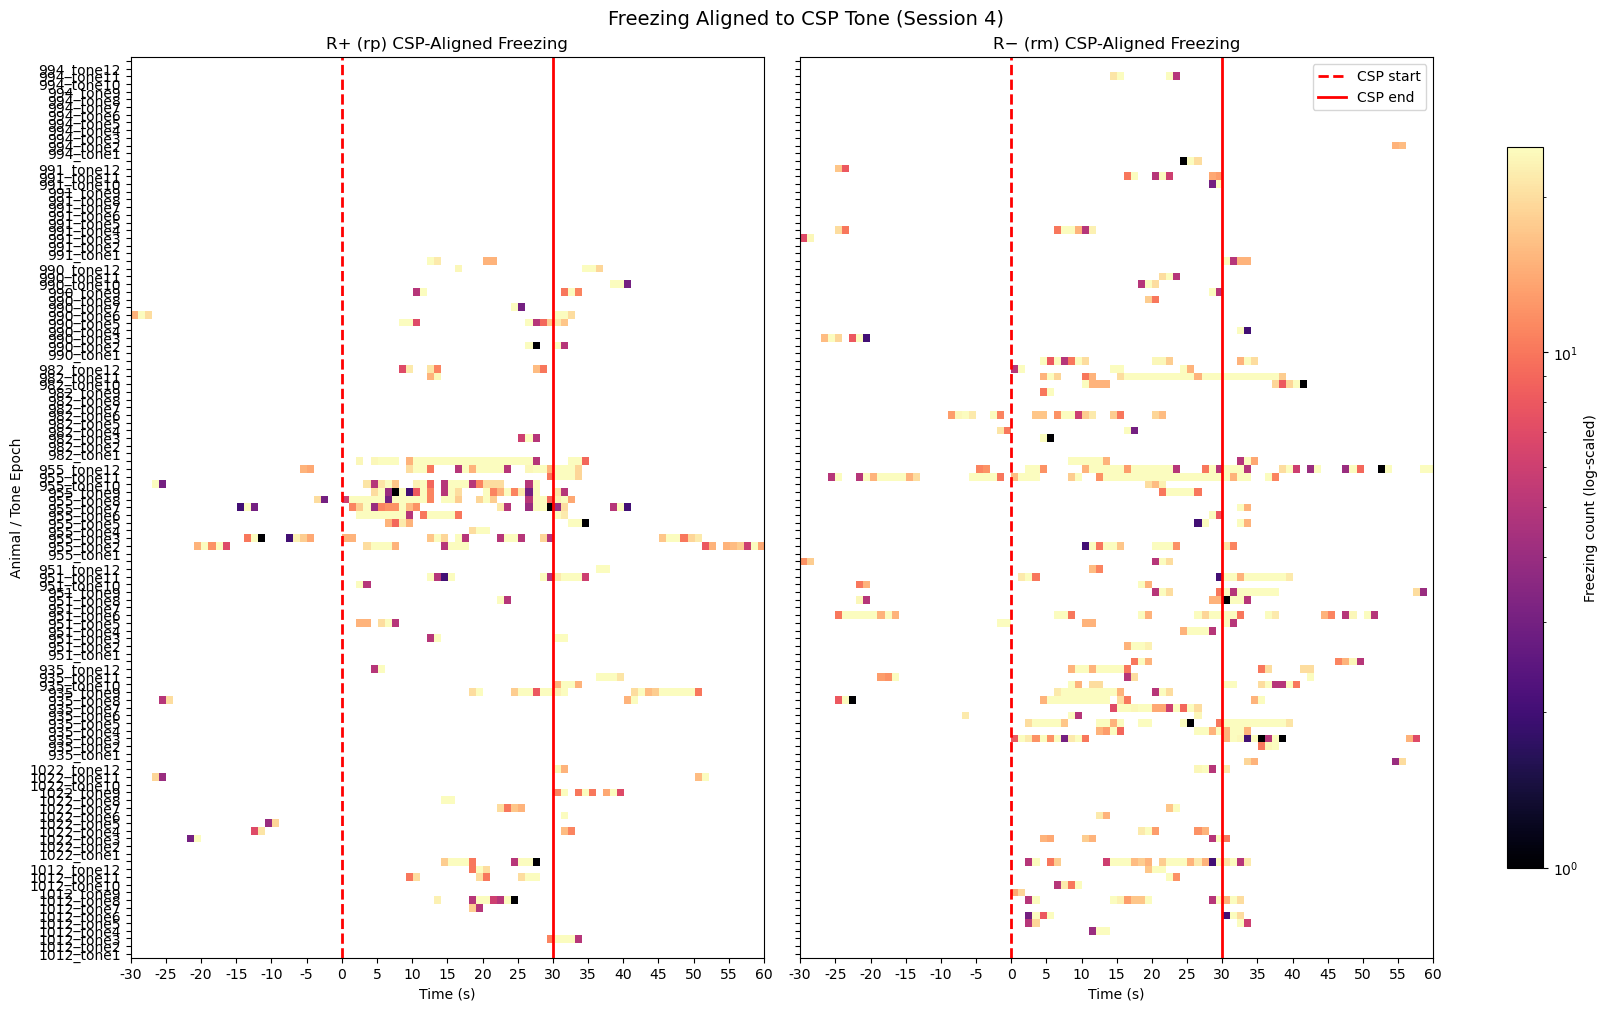

In [40]:
plot_tone_aligned_freezing_heatmap(data, shared_tone_epochs, session='4', tone_type='csp')


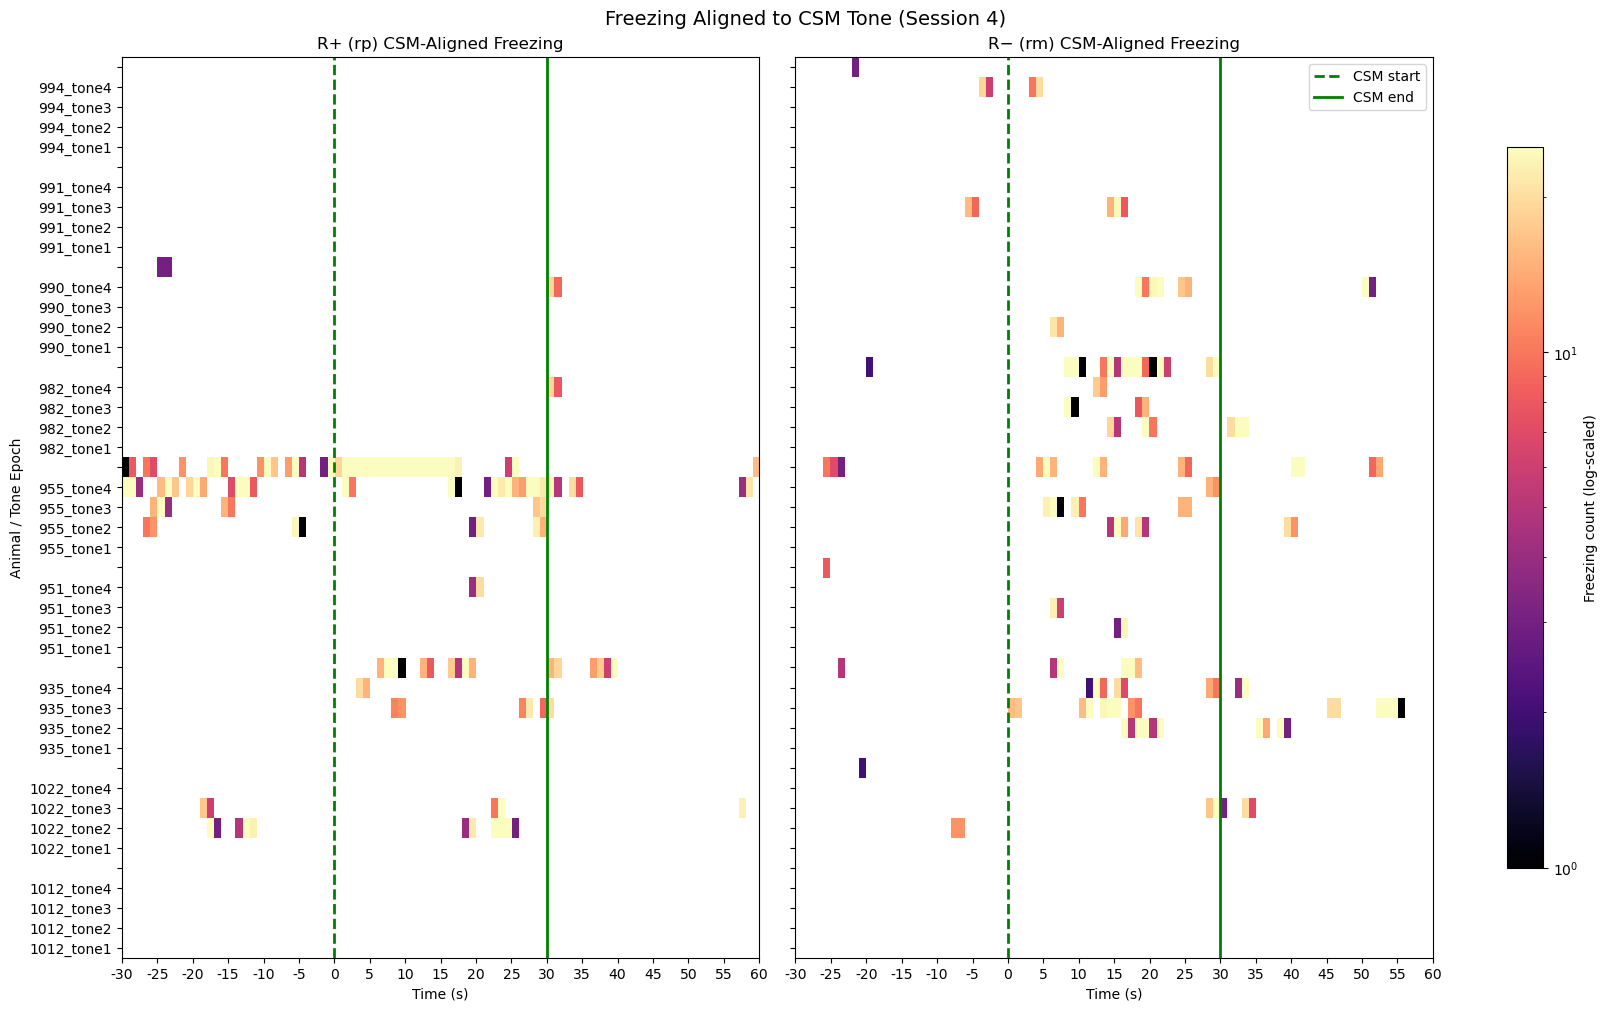

In [41]:
plot_tone_aligned_freezing_heatmap(data, shared_tone_epochs, session='4', tone_type='csm')


In [51]:
def plot_single_animal_tone_heatmap(
    data, shared_tone_epochs, base_id_short, tone_type='csp',
    sessions=['4', '5', '6', '7'], fps=25, pre_tone=30, post_tone=30, bin_size=1
):
    """
    Plots freezing heatmap for a single animal across multiple sessions (4–7),
    aligned to CS+ or CS− tones. Automatically matches full file names using base_id_short.
    
    Example:
    - base_id_short = '988_A'
    - finds files like: '988_A_s4_rm_12_4kHz', etc.
    """
    assert tone_type in ['csp', 'csm'], "tone_type must be 'csp' or 'csm'"
    frame_duration = 1 / fps

    all_epochs = []
    all_labels = []

    tone_epochs = shared_tone_epochs[tone_type]
    tone_durations = [(end - start) * frame_duration for start, end in tone_epochs]
    mean_duration = np.mean(tone_durations)
    bins = np.arange(-pre_tone, mean_duration + post_tone + bin_size, bin_size)

    all_file_keys = data.index.levels[0]

    for session in sessions:
        # Try to find the matching file key for this animal and session
        session_prefix = f"{base_id_short}_s{session}"
        matched_files = [f for f in all_file_keys if f.startswith(session_prefix)]

        if not matched_files:
            print(f"No file found for {session_prefix}")
            continue

        full_file = matched_files[0]
        df = data[(data['session'] == str(session)) & (data['freezing'] == 1)]

        try:
            file_df = df.loc[full_file]
        except KeyError:
            continue

        times = file_df['time_s'].values
        session_label = f"S{session}"

        session_epochs = []
        session_labels = []

        for i, (tone_start_f, tone_end_f) in enumerate(tone_epochs):
            tone_start_s = tone_start_f * frame_duration
            tone_dur_s = (tone_end_f - tone_start_f) * frame_duration

            start = tone_start_s - pre_tone
            end = tone_start_s + tone_dur_s + post_tone

            epoch_times = times[(times >= start) & (times < end)] - tone_start_s
            bin_counts, _ = np.histogram(epoch_times, bins=bins)
            session_epochs.append(bin_counts)
            session_labels.append(f"{session_label}_T{12 - i:02d}")

        if session_epochs:
            session_epochs = session_epochs[::-1]
            session_labels = session_labels[::-1]

            all_epochs.extend(session_epochs)
            all_labels.extend(session_labels)

            # Spacer row
            spacer = np.zeros(len(bins) - 1)
            all_epochs.append(spacer)
            all_labels.append("")

    if not all_epochs:
        print(f"No data found for {base_id_short}")
        return

    aligned_array = np.vstack(all_epochs)

    fig, ax = plt.subplots(figsize=(10, 8))

    # Log color scale
    if np.count_nonzero(aligned_array) > 0:
        norm = mcolors.LogNorm(vmin=1, vmax=aligned_array.max())
    else:
        norm = None

    im = ax.imshow(
        aligned_array,
        aspect='auto',
        cmap='magma',
        interpolation='none',
        extent=[bins[0], bins[-1], 0, aligned_array.shape[0]],
        norm=norm
    )

    xticks = bins[::5]
    xticklabels = [f"{x:.0f}" for x in xticks]
    ax.set_xticks(xticks)
    ax.set_xticklabels(xticklabels)
    ax.set_yticks(np.arange(len(all_labels)) + 0.5)
    ax.set_yticklabels(all_labels)

    color = 'red' if tone_type == 'csp' else 'green'
    ax.axvline(0, color=color, linestyle='--', linewidth=2, label='Tone Start')
    ax.axvline(mean_duration, color=color, linestyle='-', linewidth=2, label='Tone End')

    ax.set_title(f"{base_id_short} — Freezing aligned to {tone_type.upper()} (Sessions {', '.join(sessions)})")
    ax.set_xlabel("Time from tone start (s)")
    ax.set_ylabel("Tone Epochs (T12→T01 by session)")
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label("Freezing count (log-scaled)")
    ax.legend()
    plt.tight_layout()
    plt.show()


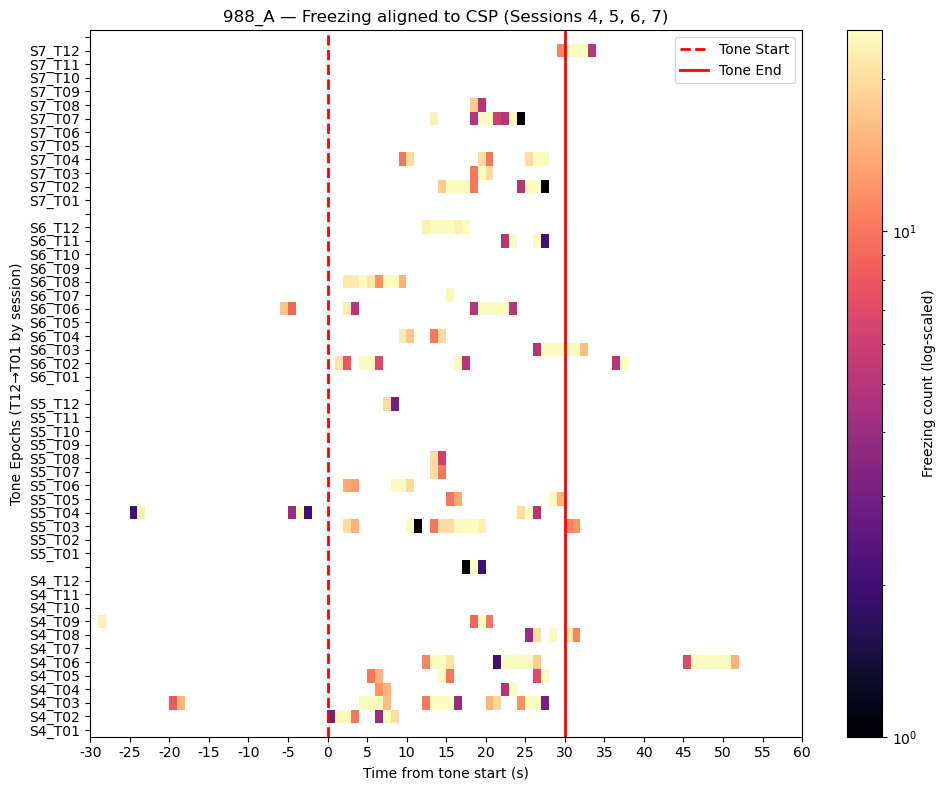

In [52]:
plot_single_animal_tone_heatmap(
    data,
    shared_tone_epochs,
    base_id_short='988_A',     # Just the animal prefix!
    tone_type='csp'            # or 'csm'
)


In [53]:
def list_animals(df):
    files = df.index.levels[0]
    animal_ids = sorted(set(f.split('_')[0] + '_' + f.split('_')[1] for f in files))
    return animal_ids


In [54]:
list_animals(rm_animals)

['1002_B',
 '1012_B',
 '1022_B',
 '1031_B',
 '1037_B',
 '934_B',
 '935_B',
 '936_A',
 '951_A',
 '955_A',
 '970_A',
 '982_A',
 '988_A',
 '990_B',
 '991_A',
 '994_A']